## Generative Adversarial Networks (GAN)

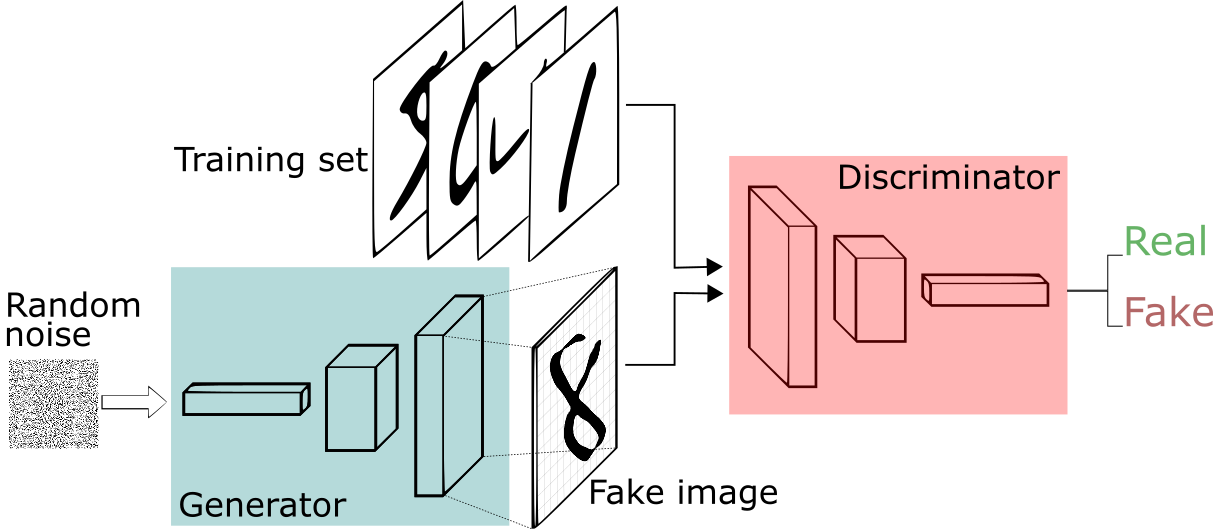

* randomness
* pooling -> strides
* ReLU -> leakyReLU

In [45]:
# MNIST
import numpy as np
from tensorflow import keras
from keras import models 
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [46]:
# generator: g(noise) -> fake image
latent_dim = 100
length = 28
channels = 1

generator_input = layers.Input(shape=(latent_dim, )) 

x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7,7,128))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(channels, kernel_size=5, strides=2, activation='tanh', padding='same')(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)      

In [47]:
discriminator_input = layers.Input(shape=(length, length, channels))

x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,  kernel_size=5, strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
 
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x) # 분류

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer='nadam')


Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)       

In [48]:
gin = layers.Input(shape=(latent_dim,))
gout = discriminator(generator(gin))

gan = models.Model(gin, gout) 

discriminator.trainable = False # discriminator는 훈련하지 않음
gan.compile(loss='binary_crossentropy', optimizer='nadam')
gan.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
functional_25 (Functional)   (None, 28, 28, 1)         840705    
_________________________________________________________________
functional_27 (Functional)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


#### GAN training
1. random noise
2. generator(noise)
3. real images / fake images
4. discriminator

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = X_train/255
X_train = X_train*2 -1

In [50]:
batch_size = 64
epochs = 1001

def gan_train(epochs, batch_size):    
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        img = X_train[idx]
        loss_real = discriminator.train_on_batch(img, true)
 
        # fake 이미지
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen = generator.predict(noise)
        loss_fake = discriminator.train_on_batch(gen, fake)
 
        # 오차 계산
        d_loss = 0.5 * np.add(loss_real, loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        
        if i % 100 == 0:
            noise = np.random.normal(0,1,(batch_size,latent_dim))
            im=generator.predict(noise)
            plt.figure()
            
            plt.subplot(141)
            plt.imshow(im[0, :, :, 0])
            
            plt.subplot(142)
            plt.imshow(im[1, :, :, 0])

            plt.subplot(143)
            plt.imshow(im[2, :, :, 0])

            plt.subplot(144)
            plt.imshow(im[3, :, :, 0])

            plt.show()
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

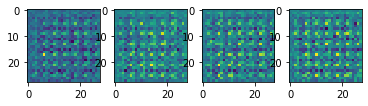

epoch:0  d_loss:0.6737  g_loss:0.6152


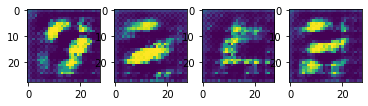

epoch:100  d_loss:0.6366  g_loss:2.0661


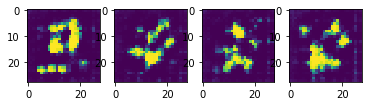

epoch:200  d_loss:0.7602  g_loss:1.4518


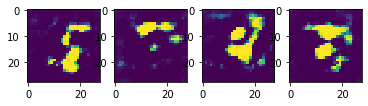

epoch:300  d_loss:0.6283  g_loss:2.0572


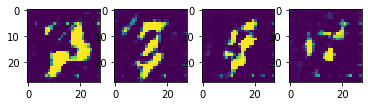

epoch:400  d_loss:0.7244  g_loss:1.2247


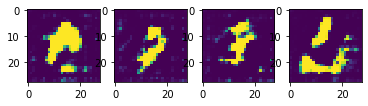

epoch:500  d_loss:0.5943  g_loss:1.5608


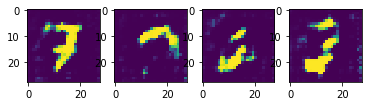

epoch:600  d_loss:0.5347  g_loss:1.7088


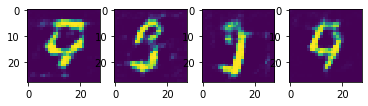

epoch:700  d_loss:0.6545  g_loss:1.5038


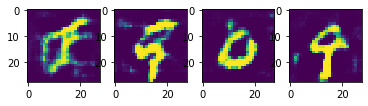

epoch:800  d_loss:0.6058  g_loss:1.4298


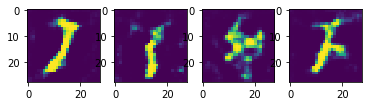

epoch:900  d_loss:0.5889  g_loss:1.2905


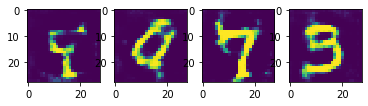

epoch:1000  d_loss:0.6279  g_loss:1.2455


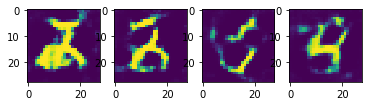

epoch:1100  d_loss:0.6824  g_loss:1.1646


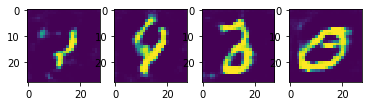

epoch:1200  d_loss:0.6291  g_loss:1.3187


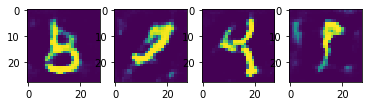

epoch:1300  d_loss:0.6481  g_loss:1.1016


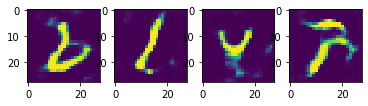

epoch:1400  d_loss:0.6418  g_loss:1.2573


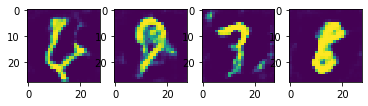

epoch:1500  d_loss:0.5901  g_loss:1.1906


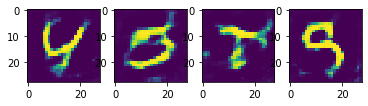

epoch:1600  d_loss:0.6589  g_loss:1.0855


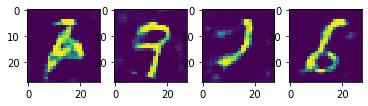

epoch:1700  d_loss:0.7134  g_loss:1.0365


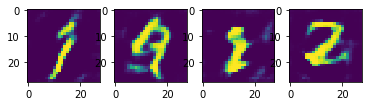

epoch:1800  d_loss:0.6135  g_loss:1.0737


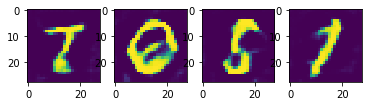

epoch:1900  d_loss:0.6584  g_loss:1.1175


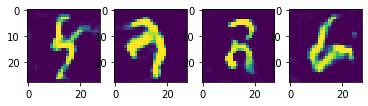

epoch:2000  d_loss:0.6751  g_loss:1.1829


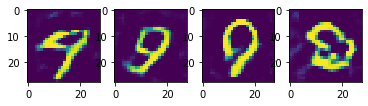

epoch:2100  d_loss:0.6511  g_loss:1.0841


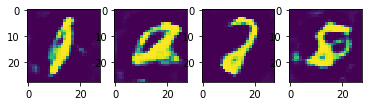

epoch:2200  d_loss:0.5910  g_loss:1.1498


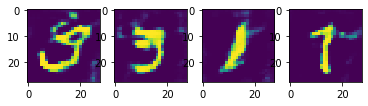

epoch:2300  d_loss:0.7116  g_loss:1.0427


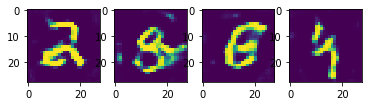

epoch:2400  d_loss:0.6494  g_loss:1.0923


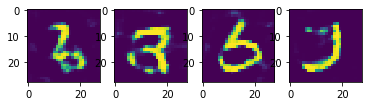

epoch:2500  d_loss:0.7007  g_loss:1.2036


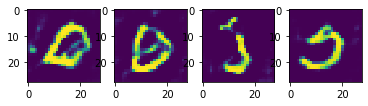

epoch:2600  d_loss:0.5958  g_loss:1.0994


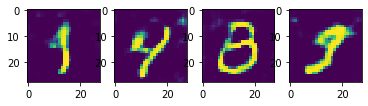

epoch:2700  d_loss:0.6201  g_loss:1.1536


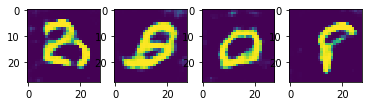

epoch:2800  d_loss:0.5701  g_loss:1.2114


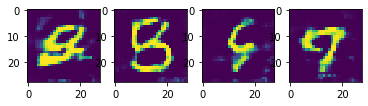

epoch:2900  d_loss:0.6381  g_loss:1.1711


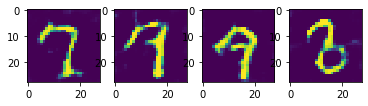

epoch:3000  d_loss:0.6687  g_loss:1.1931


In [51]:
epochs = 3001
batch_size = 64
gan_train(epochs,batch_size)

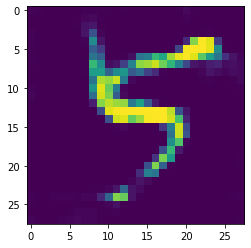

In [52]:
noise = np.random.normal(0,1,(batch_size,latent_dim))
im=generator.predict(noise)
plt.imshow(im[0, :, :, 0])

#### This person does not exist
* https://thispersondoesnotexist.com/